In [1]:
!pip install sktime[all_extras]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 6.8 MB/s 
     |████████████████████████████████| 9.8 MB 46.4 MB/s 
     |████████████████████████████████| 11.2 MB 42.8 MB/s 
     |████████████████████████████████| 6.9 MB 31.8 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 2.5 MB 45.2 MB/s 
     |████████████████████████████████| 136 kB 43.9 MB/s 
     |████████████████████████████████| 228 kB 56.9 MB/s 
     |████████████████████████████████| 634 kB 49.1 MB/s 
     |████████████████████████████████| 177 kB 47.8 MB/s 
     |████████████████████████████████| 1.4 MB 50.4 MB/s 
     |████████████████████████████████| 793 kB 43.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 7.5 MB 38.8 MB/s 
     |████████████████████████████████| 134 kB 50.1 MB/s 
     |█████████████████████████████

In [40]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.arima import ARIMA
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import MinMaxScaler
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster, ForecastingPipeline


In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor
from prophet import Prophet

In [198]:
# Setting config for the seaborn plots
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [199]:
df = pd.read_csv("/content/electricity_univariate.csv")

In [200]:
df.head()

,time,MT_004
0,2011-01-01 00:15:00,0.0
1,2011-01-01 00:30:00,0.0
2,2011-01-01 00:45:00,0.0
3,2011-01-01 01:00:00,0.0
4,2011-01-01 01:15:00,0.0


In [201]:
df = (df.assign(time=pd.to_datetime(df.time)).
      set_index("time").
      rename(columns={"MT_004":"vals"}))

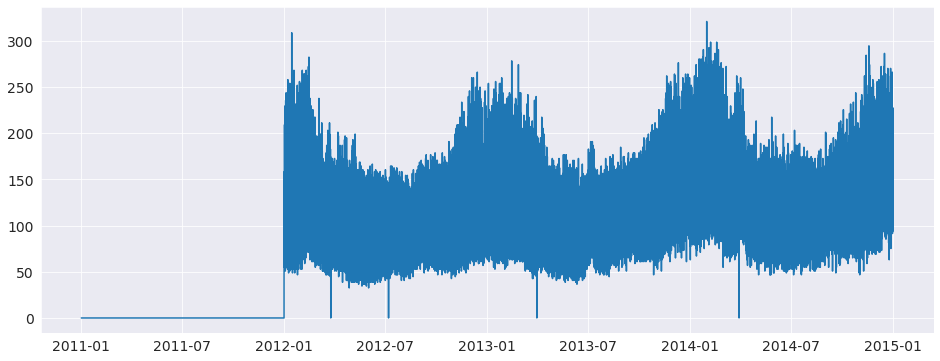

In [202]:
plt.plot(df["vals"])

In [203]:
df = df["2012":"2015"]

In [204]:
df = df.resample("D").mean()

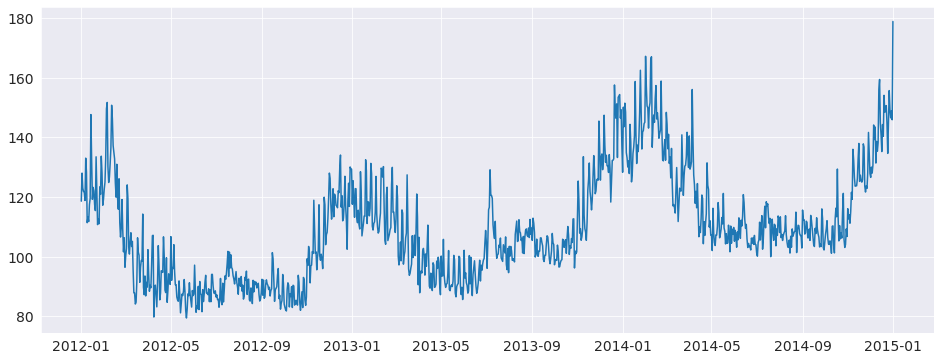

In [205]:
plt.plot(df["vals"])

In [206]:
y_train, y_test = temporal_train_test_split(df,test_size=0.1)

In [207]:
res = seasonal_decompose(y_train)

[]

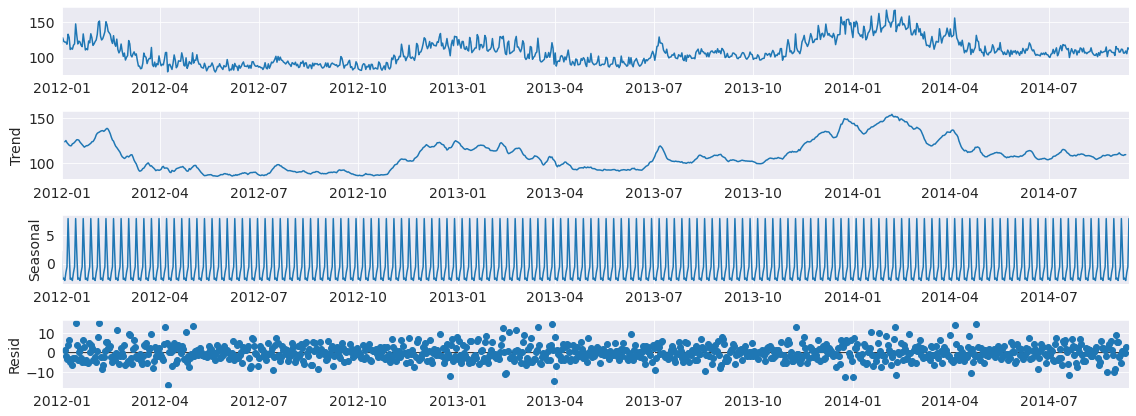

In [208]:
res.plot()
plt.plot()

In [209]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction


regressor = RandomForestRegressor()
model = make_reduction(regressor, window_length=300, strategy="recursive")

fh = ForecastingHorizon(y_test.index, is_relative=False)

In [210]:
model.fit(y_train)

y_pred = model.predict(fh)

mean_absolute_percentage_error(y_test, y_pred)

0.12107899808913651

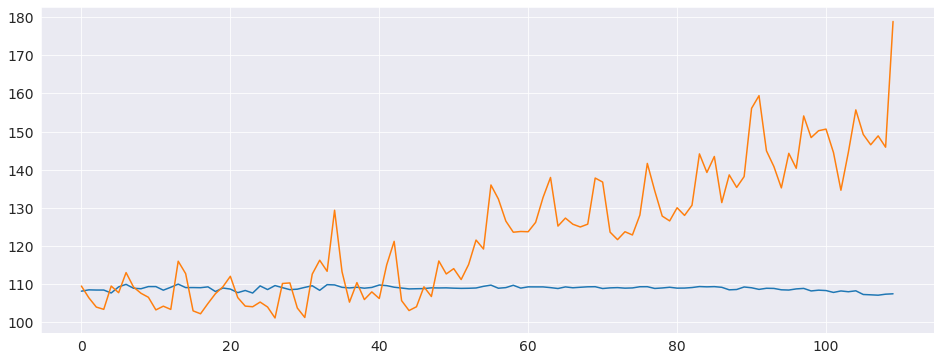

In [211]:
plt.plot(y_pred.values)
plt.plot(y_test.values)

In [212]:
datefeatures = DateTimeFeatures()

In [213]:
X = df.drop("vals",axis=1)

In [214]:
Y = df["vals"]

In [215]:
y_train, y_test, x_train, x_test = temporal_train_test_split(Y,X=X,test_size=0.1)

In [216]:
x_train = datefeatures.fit_transform(x_train)
x_test = datefeatures.transform(x_test)

In [218]:
x_train.head()

,year,month_of_year,day_of_week,hour_of_day,minute_of_hour,second_of_minute,millisecond_of_second
time,,,,,,,
2012-01-01,2012,1,6,0,0,0,0
2012-01-02,2012,1,0,0,0,0,0
2012-01-03,2012,1,1,0,0,0,0
2012-01-04,2012,1,2,0,0,0,0
2012-01-05,2012,1,3,0,0,0,0


In [220]:

minmaxscaler = TabularToSeriesAdaptor(MinMaxScaler())

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)

forecaster = TransformedTargetForecaster(
    [
     ('minmaxscale', minmaxscaler),
     ('reduce', make_reduction(regressor, window_length=60, strategy="recursive"))
    ]
)

pipeline = ForecastingPipeline(
    [
     ('minmaxscale', minmaxscaler),
     ('forecast', forecaster), 
    ]
)

pipeline.fit(y_train,X=x_train)

ForecastingPipeline(steps=[('minmaxscale',
                            TabularToSeriesAdaptor(transformer=MinMaxScaler())),
                           ('forecast',
                            TransformedTargetForecaster(steps=[('minmaxscale',
                                                                TabularToSeriesAdaptor(transformer=MinMaxScaler())),
                                                               ('reduce',
                                                                RecursiveTabularRegressionForecaster(estimator=XGBRegressor(objective='reg:squarederror',
                                                                                                                            random_state=42),
                                                                                                     window_length=60))]))])

In [221]:
y_pred = pipeline.predict(fh,x_test)

mean_absolute_percentage_error(y_test, y_pred)

0.0935598634795685

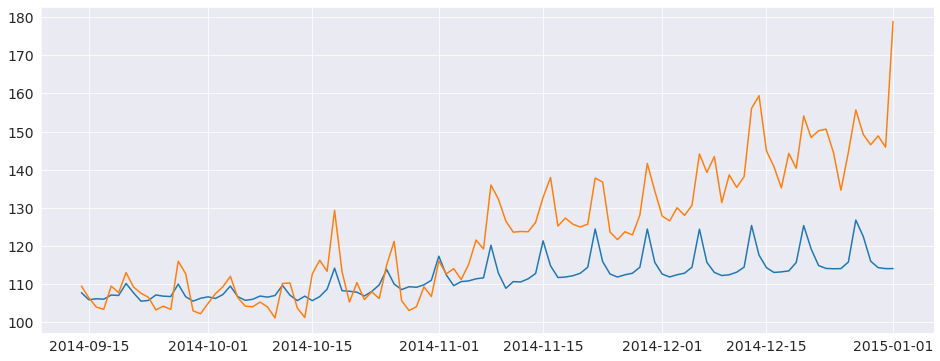

In [222]:
plt.plot(y_test.index,y_pred.values)
plt.plot(y_test.index,y_test.values)

In [223]:
m = Prophet()
m.fit(df.reset_index().rename(columns={"time":"ds","vals":"y"}))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7u4d2d_/0lios_3g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7u4d2d_/0yyn_qgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22146', 'data', 'file=/tmp/tmpt7u4d2d_/0lios_3g.json', 'init=/tmp/tmpt7u4d2d_/0yyn_qgj.json', 'output', 'file=/tmp/tmpgaror05u/prophet_model-20220816115918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:59:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [227]:
future = m.make_future_dataframe(periods=60)

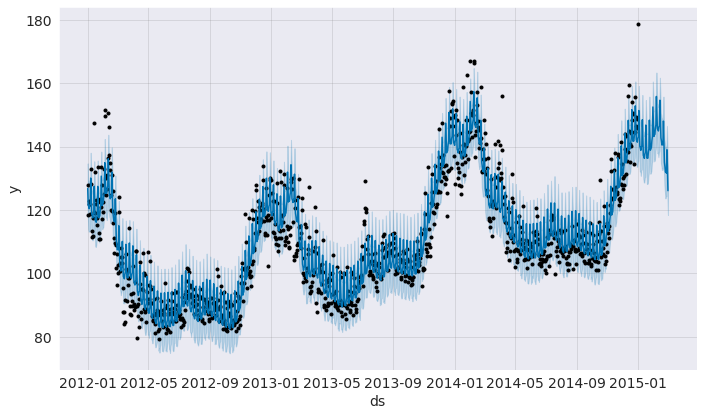

In [228]:
fcst = m.predict(future)
fig = m.plot(fcst)

In [233]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='30 days', horizon = '60 days')

INFO:prophet:Making 11 forecasts with cutoffs between 2014-01-06 00:00:00 and 2014-11-02 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7u4d2d_/toyus6tf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7u4d2d_/co_6pmch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50948', 'data', 'file=/tmp/tmpt7u4d2d_/toyus6tf.json', 'init=/tmp/tmpt7u4d2d_/co_6pmch.json', 'output', 'file=/tmp/tmpvpt54a1q/prophet_model-20220816120302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:03:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7u4d2d_/dhac0abm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7u4d2d_/3hv_haad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

In [230]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-02,137.773575,130.302463,145.031557,150.110095,2014-01-01
1,2014-01-03,138.513339,130.814631,145.542782,143.567920,2014-01-01
2,2014-01-04,146.851864,139.067567,154.375355,151.465108,2014-01-01
3,2014-01-05,141.320319,134.122577,148.791731,148.458672,2014-01-01
4,2014-01-06,135.726005,128.017566,142.851154,134.887364,2014-01-01


In [234]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
50,56 days,164.512474,12.826242,10.790918,0.092953,0.082468,0.089711,0.378788
51,57 days,173.865800,13.185818,11.195566,0.096986,0.085372,0.093378,0.348485
52,58 days,176.674418,13.291893,11.316339,0.097752,0.089144,0.094220,0.333333
53,59 days,193.092618,13.895777,11.954410,0.102595,0.090887,0.099011,0.318182
54,60 days,223.433445,14.947690,12.383566,0.104346,0.092816,0.101303,0.333333


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


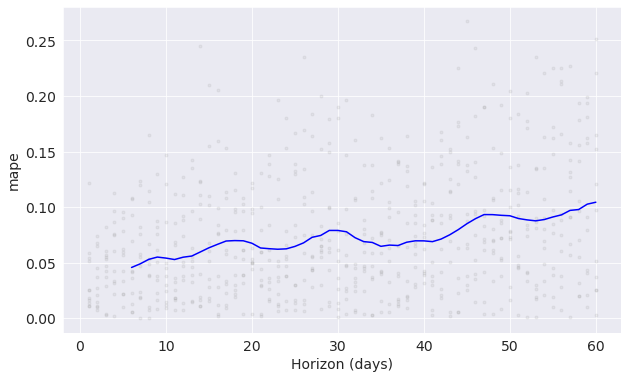

In [235]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

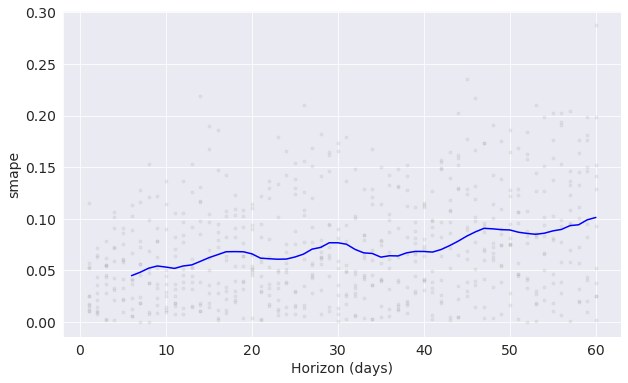

In [236]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='smape')